### Get OpenStreetMap Features
* Map features: https://wiki.openstreetmap.org/wiki/Map_features

In [56]:
# Packages
import osmnx as ox
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews as gv
from shapely.geometry import box

In [241]:
# Functions
def buffer_aoi(gdf_aoi, buffer=1000):
    # Reproject to EPSG:3857
    crs = gdf_aoi.crs
    gdf_aoi = gdf_aoi.to_crs('EPSG:3857')

    # Buffer area of interest
    gdf_aoi['geometry'] = gdf_aoi.buffer(buffer)

    # Reproject back to original crs
    gdf_aoi = gdf_aoi.to_crs(crs)
    
    # Return buffered aoi
    return gdf_aoi

def features_from_aoi(gdf_aoi, tags, clip='false'):
    # Get bounds
    bounds = gdf_aoi.total_bounds

    # Get features from bbox
    try:
        gdf_features = ox.features_from_bbox(bounds, tags)
    except ox._errors.InsufficientResponseError:
        gdf_features = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_aoi.crs)
    
    # Clip features to bbox
    if clip == 'aoi':
        gdf_features = gdf_features.clip(gdf_aoi)
    if clip == 'box':
        gdf_features = gdf_features.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
    # Return features
    return gdf_features

In [311]:
# Define geographic area of interest
geocode_aoi = "Rotterdam, Netherlands"
#geocode_aoi = "Amsterdam, Netherlands"
#geocode_aoi = "London, United Kingdom"
#geocode_aoi = "Berlin, Germany"
#geocode_aoi = "Munich, Germany"
#geocode_aoi = "Istanbul, Turkey"

# Get area of interest
gdf_aoi = ox.geocode_to_gdf(geocode_aoi)
#gdf_aoi = gpd.GeoDataFrame(data={'geometry': [box(4.3, 51.92, 4.7, 51.94)], 'name': ['bbox']}, crs=gdf_aoi.crs)
#gdf_aoi = gpd.GeoDataFrame(data={'geometry': [box(4.45, 51.86, 4.50, 52.0)], 'name': ['bbox']}, crs=gdf_aoi.crs)

# Get buffered area of interest
gdf_buffer = buffer_aoi(gdf_aoi, buffer=1000)

# Get bounding box
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*gdf_buffer.total_bounds)], 'name': ['bbox']}, crs=gdf_buffer.crs)

# Get bounding box to fit on A3 paper
bounds = gdf_bbox.total_bounds
centre = (bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2
width = (bounds[2] - bounds[0])
height = bounds[3] - bounds[1]
if width > height:
    if width < height * np.sqrt(2) / np.cos(60*np.pi/180):
         width = height * np.sqrt(2) / np.cos(60*np.pi/180)
    else:
        height = width * np.cos(60*np.pi/180) / np.sqrt(2)
elif height > width:
    if height < width * np.sqrt(2) * np.cos(60*np.pi/180):
         height = width * np.sqrt(2) * np.cos(60*np.pi/180)
    else:
        width = height / np.cos(60*np.pi/180) / np.sqrt(2)
bounds = centre[1] - width / 2, centre[0] - height / 2, centre[1] + width / 2, centre[0] + height / 2
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*bounds)], 'name': ['bbox']}, crs=gdf_buffer.crs)

# Get limits
bounds = gdf_bbox.total_bounds
xlim = (bounds[0], bounds[2])
ylim = (bounds[1], bounds[3])

# Get suburbs
gdf_suburbs = features_from_aoi(gdf_buffer, tags={"place": "suburb"})
gdf_suburbs = gdf_suburbs.clip(gdf_aoi)
gdf_suburbs = gdf_suburbs[np.logical_or(gdf_suburbs.geom_type == "Polygon", gdf_suburbs.geom_type == "MultiPolygon")]

# Get train lines
gdf_train_lines = features_from_aoi(gdf_buffer, tags={"railway": "rail"})
if "usage"  in gdf_train_lines.columns:
    gdf_train_lines = gdf_train_lines[gdf_train_lines["usage"].isin(["main", "branch"])]

# Get metro lines
gdf_metro_lines = features_from_aoi(gdf_buffer, tags={"railway": "subway"})
if "service" in gdf_metro_lines.columns:
    gdf_metro_lines = gdf_metro_lines[~gdf_metro_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get light rail lines
gdf_light_rail_lines = features_from_aoi(gdf_buffer, tags={"railway": "light_rail"})

# Get tram lines
gdf_tram_lines = features_from_aoi(gdf_buffer, tags={"railway": "tram"})
#if "service" in gdf_tram_lines.columns:
#    gdf_tram_lines = gdf_tram_lines[~gdf_tram_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get train, metro, light rail stations
gdf_stations = features_from_aoi(gdf_buffer, tags={"railway": "station"})
gdf_stations["geometry"] = gdf_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" and x.geom_type != "MultiPoint" else x)
if "station" in gdf_stations.columns:
    gdf_train_stations = gdf_stations[~gdf_stations["station"].isin(["subway", "light_rail"])]
    gdf_metro_stations = gdf_stations[gdf_stations["station"].isin(["subway"])]
    gdf_light_rail_stations = gdf_stations[gdf_stations["station"].isin(["light_rail"])]
    gdf_tram_stations = gdf_stations[gdf_stations["station"].isin(["tram"])]

# Get tram stations
gdf_tram_stations = features_from_aoi(gdf_buffer, tags={"railway": "tram_stop"})
gdf_tram_stations["geometry"] = gdf_tram_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" else x)

# Remove museum tramstation amsterdam
#gdf_tram_stations = gdf_tram_stations[gdf_tram_stations["wikidata"].notna()] 

In [312]:
# Keep name and geometry
gdf_aoi = gdf_aoi[["name", "geometry"]].reset_index(drop=True)
gdf_buffer = gdf_buffer[["name", "geometry"]].reset_index(drop=True)
gdf_bbox = gdf_bbox[["name", "geometry"]].reset_index(drop=True)
'''
gdf_suburbs = gdf_suburbs[["name", "geometry"]].reset_index(drop=True)
gdf_train_stations = gdf_train_stations[["name", "geometry"]].reset_index(drop=True)
gdf_metro_stations = gdf_metro_stations[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_stations = gdf_light_rail_stations[["name", "geometry"]].reset_index(drop=True)
gdf_tram_stations = gdf_tram_stations[["name", "geometry"]].reset_index(drop=True)
gdf_train_lines = gdf_train_lines[["name", "geometry"]].reset_index(drop=True)
gdf_metro_lines = gdf_metro_lines[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_lines = gdf_light_rail_lines[["name", "geometry"]].reset_index(drop=True)
gdf_tram_lines = gdf_tram_lines[["name", "geometry"]].reset_index(drop=True)
'''

'\ngdf_suburbs = gdf_suburbs[["name", "geometry"]].reset_index(drop=True)\ngdf_train_stations = gdf_train_stations[["name", "geometry"]].reset_index(drop=True)\ngdf_metro_stations = gdf_metro_stations[["name", "geometry"]].reset_index(drop=True)\ngdf_light_rail_stations = gdf_light_rail_stations[["name", "geometry"]].reset_index(drop=True)\ngdf_tram_stations = gdf_tram_stations[["name", "geometry"]].reset_index(drop=True)\ngdf_train_lines = gdf_train_lines[["name", "geometry"]].reset_index(drop=True)\ngdf_metro_lines = gdf_metro_lines[["name", "geometry"]].reset_index(drop=True)\ngdf_light_rail_lines = gdf_light_rail_lines[["name", "geometry"]].reset_index(drop=True)\ngdf_tram_lines = gdf_tram_lines[["name", "geometry"]].reset_index(drop=True)\n'

C:\Users\Ruben\AppData\Local\Temp\ipykernel_22596\3352960821.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right', fontsize=8)


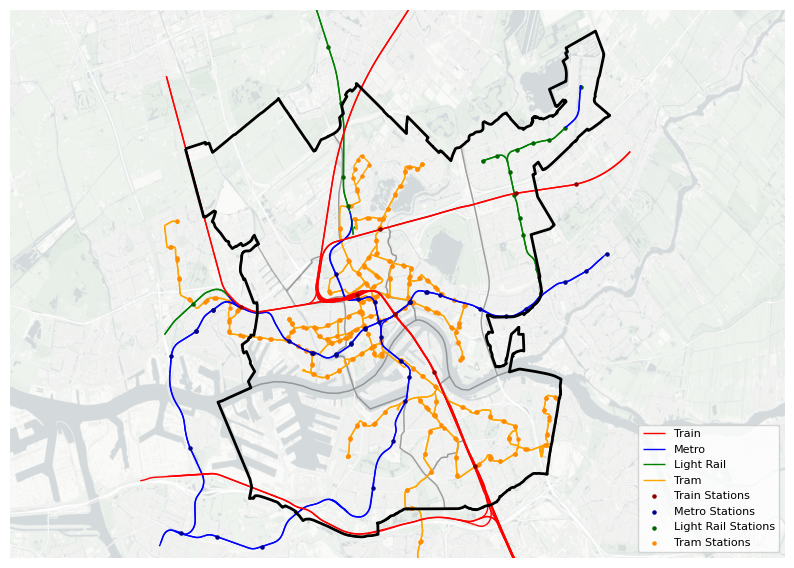

In [323]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, label="Area of Intrest", zorder=3)
#gdf_buffer.plot(ax=ax, facecolor='none', edgecolor="blue", linewidth=1, linestyle='--', label="Buffer", zorder=2)
gdf_suburbs.plot(ax=ax, facecolor='none', edgecolor="grey", linewidth=1, linestyle='-', label="Suburbs", alpha=0.5)
#gdf_bbox.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, linestyle='-', label="Bounding Box", zorder=1)

if not gdf_train_stations.empty:
    gdf_train_lines.plot(ax=ax, color="red", linewidth=1, label="Train", zorder=1.4)
if not gdf_metro_lines.empty:
    gdf_metro_lines.plot(ax=ax, color="blue", linewidth=1, label="Metro", zorder=1.3)
if not gdf_light_rail_lines.empty:
    gdf_light_rail_lines.plot(ax=ax, color="green", linewidth=1, label="Light Rail", zorder=1.2)
if not gdf_tram_lines.empty:
    gdf_tram_lines.plot(ax=ax, color="orange", linewidth=1, label="Tram", zorder=1.1)

if not gdf_train_stations.empty:
    gdf_train_stations.plot(ax=ax, color="darkred", markersize=5, label="Train Stations", zorder=1.4)
if not gdf_metro_stations.empty:
    gdf_metro_stations.plot(ax=ax, color="darkblue", markersize=5, label="Metro Stations", zorder=1.3)
if not gdf_light_rail_stations.empty:
    gdf_light_rail_stations.plot(ax=ax, color="darkgreen", markersize=5, label="Light Rail Stations", zorder=1.2)
if not gdf_tram_stations.empty:
    gdf_tram_stations.plot(ax=ax, color="darkorange", markersize=5, label="Tram Stations", zorder=1.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()
ax.set_aspect(1.0/np.cos(60*np.pi/180))
cx.add_basemap(ax, crs=gdf_train_lines.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, zoom=13)
ax.legend(loc='lower right', fontsize=8)
plt.show()

In [52]:
# Plot all lines and stations
plot_map = gv.tile_sources.CartoLight
plot_aoi = gdf_aoi.hvplot(geo=True, line_width=2, line_color="black", fill_color="none")
plot_districts = gdf_districts.hvplot(geo=True, line_width=2, line_color="black", line_dash="dashed", fill_color="none")

plot_train_lines = gdf_train_lines.hvplot(geo=True, line_width=2, line_color="red")
plot_metro_lines = gdf_metro_lines.hvplot(geo=True, line_width=2, line_color="blue")
plot_light_rail_lines = gdf_light_rail_lines.hvplot(geo=True, line_width=2, line_color="green")
plot_tram_lines = gdf_tram_lines.hvplot(geo=True, line_width=2, line_color="orange")

plot_train_stations = gdf_train_stations.hvplot(geo=True, color="darkred", size=20)
plot_metro_stations = gdf_metro_stations.hvplot(geo=True, color="darkblue", size=20)
plot_light_rail_stations = gdf_light_rail_stations.hvplot(geo=True, color="darkgreen", size=20)
plot_tram_stations = gdf_tram_stations.hvplot(geo=True, color="darkorange", size=20)

(plot_map * plot_tram_lines * plot_tram_stations * plot_light_rail_lines * plot_light_rail_stations *
 plot_metro_lines * plot_metro_stations * plot_train_lines * plot_train_stations * plot_aoi).opts(width=800, height=800)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]
   .Path.II    :Path   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]
   .Path.III   :Path   [Longitude,Latitude]
   .Points.III :Points   [Longitude,Latitude]
   .Path.IV    :Path   [Longitude,Latitude]
   .Points.IV  :Points   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [8]:
# Write geojsons
gdf_aoi.to_file("aoi.geojson", driver="GeoJSON")
gdf_districts.to_file("districts.geojson", driver="GeoJSON")
gdf_train_lines.to_file("train_lines.geojson", driver="GeoJSON")
gdf_metro_lines.to_file("metro_lines.geojson", driver="GeoJSON")
gdf_light_rail_lines.to_file("light_rail_lines.geojson", driver="GeoJSON")
gdf_tram_lines.to_file("tram_lines.geojson", driver="GeoJSON")
gdf_train_stations.to_file("train_stations.geojson", driver="GeoJSON")
gdf_metro_stations.to_file("metro_stations.geojson", driver="GeoJSON")
gdf_light_rail_stations.to_file("light_rail_stations.geojson", driver="GeoJSON")
gdf_tram_stations.to_file("tram_stations.geojson", driver="GeoJSON")